In [1]:
import os
import pygmt
import numpy as np
import matplotlib.pyplot as plt

grdfile = './Data/earth_relief_10m.nc'
profile_line_file = 'test.gmt'


def gmt_grdtrack(
    line_coordinates,
    gridfile,
    cross_track_width,
    along_track_spacing,
    cross_track_spacing):

    if type(line_coordinates) is str:
        cmd = 'gmt grdtrack %s -G%s -C%sk/%sk/%sk -Ar > table.txt' % \
            (line_coordinates,gridfile,cross_track_width,along_track_spacing,cross_track_spacing)
    else:
        np.savetxt('./.tmp.xy',line_coordinates)
        cmd = 'gmt grdtrack .tmp.xy -G%s -C%sk/%sk/%sk -Ar -: > table.txt' % \
            (gridfile,cross_track_width,along_track_spacing,cross_track_spacing)

    os.system(cmd)
    Xr=[]
    Yr=[]
    G=[]
    with open('./table.txt') as f:
        for line in f:
            if line[0] == '>':
                continue
            else:
                tmp = line.split()
                Xr.append(float(tmp[0]))
                Yr.append(float(tmp[1]))
                G.append(float(tmp[4]))
    
    ReshapeFactor = int((int(cross_track_spacing)*int(cross_track_width)/(int(cross_track_spacing)*int(along_track_spacing)))+1)
    
    swath_longitudes = np.reshape(Xr,(int(len(Xr)/ReshapeFactor),ReshapeFactor))
    swath_latitudes = np.reshape(Yr,(int(len(Yr)/ReshapeFactor),ReshapeFactor))
    swath_zvalues = np.reshape(G,(int(len(G)/ReshapeFactor),ReshapeFactor))
    
    along_track_distance = np.arange(swath_zvalues.shape[0])*along_track_spacing
    
    return along_track_distance, swath_longitudes, swath_latitudes, swath_zvalues
    


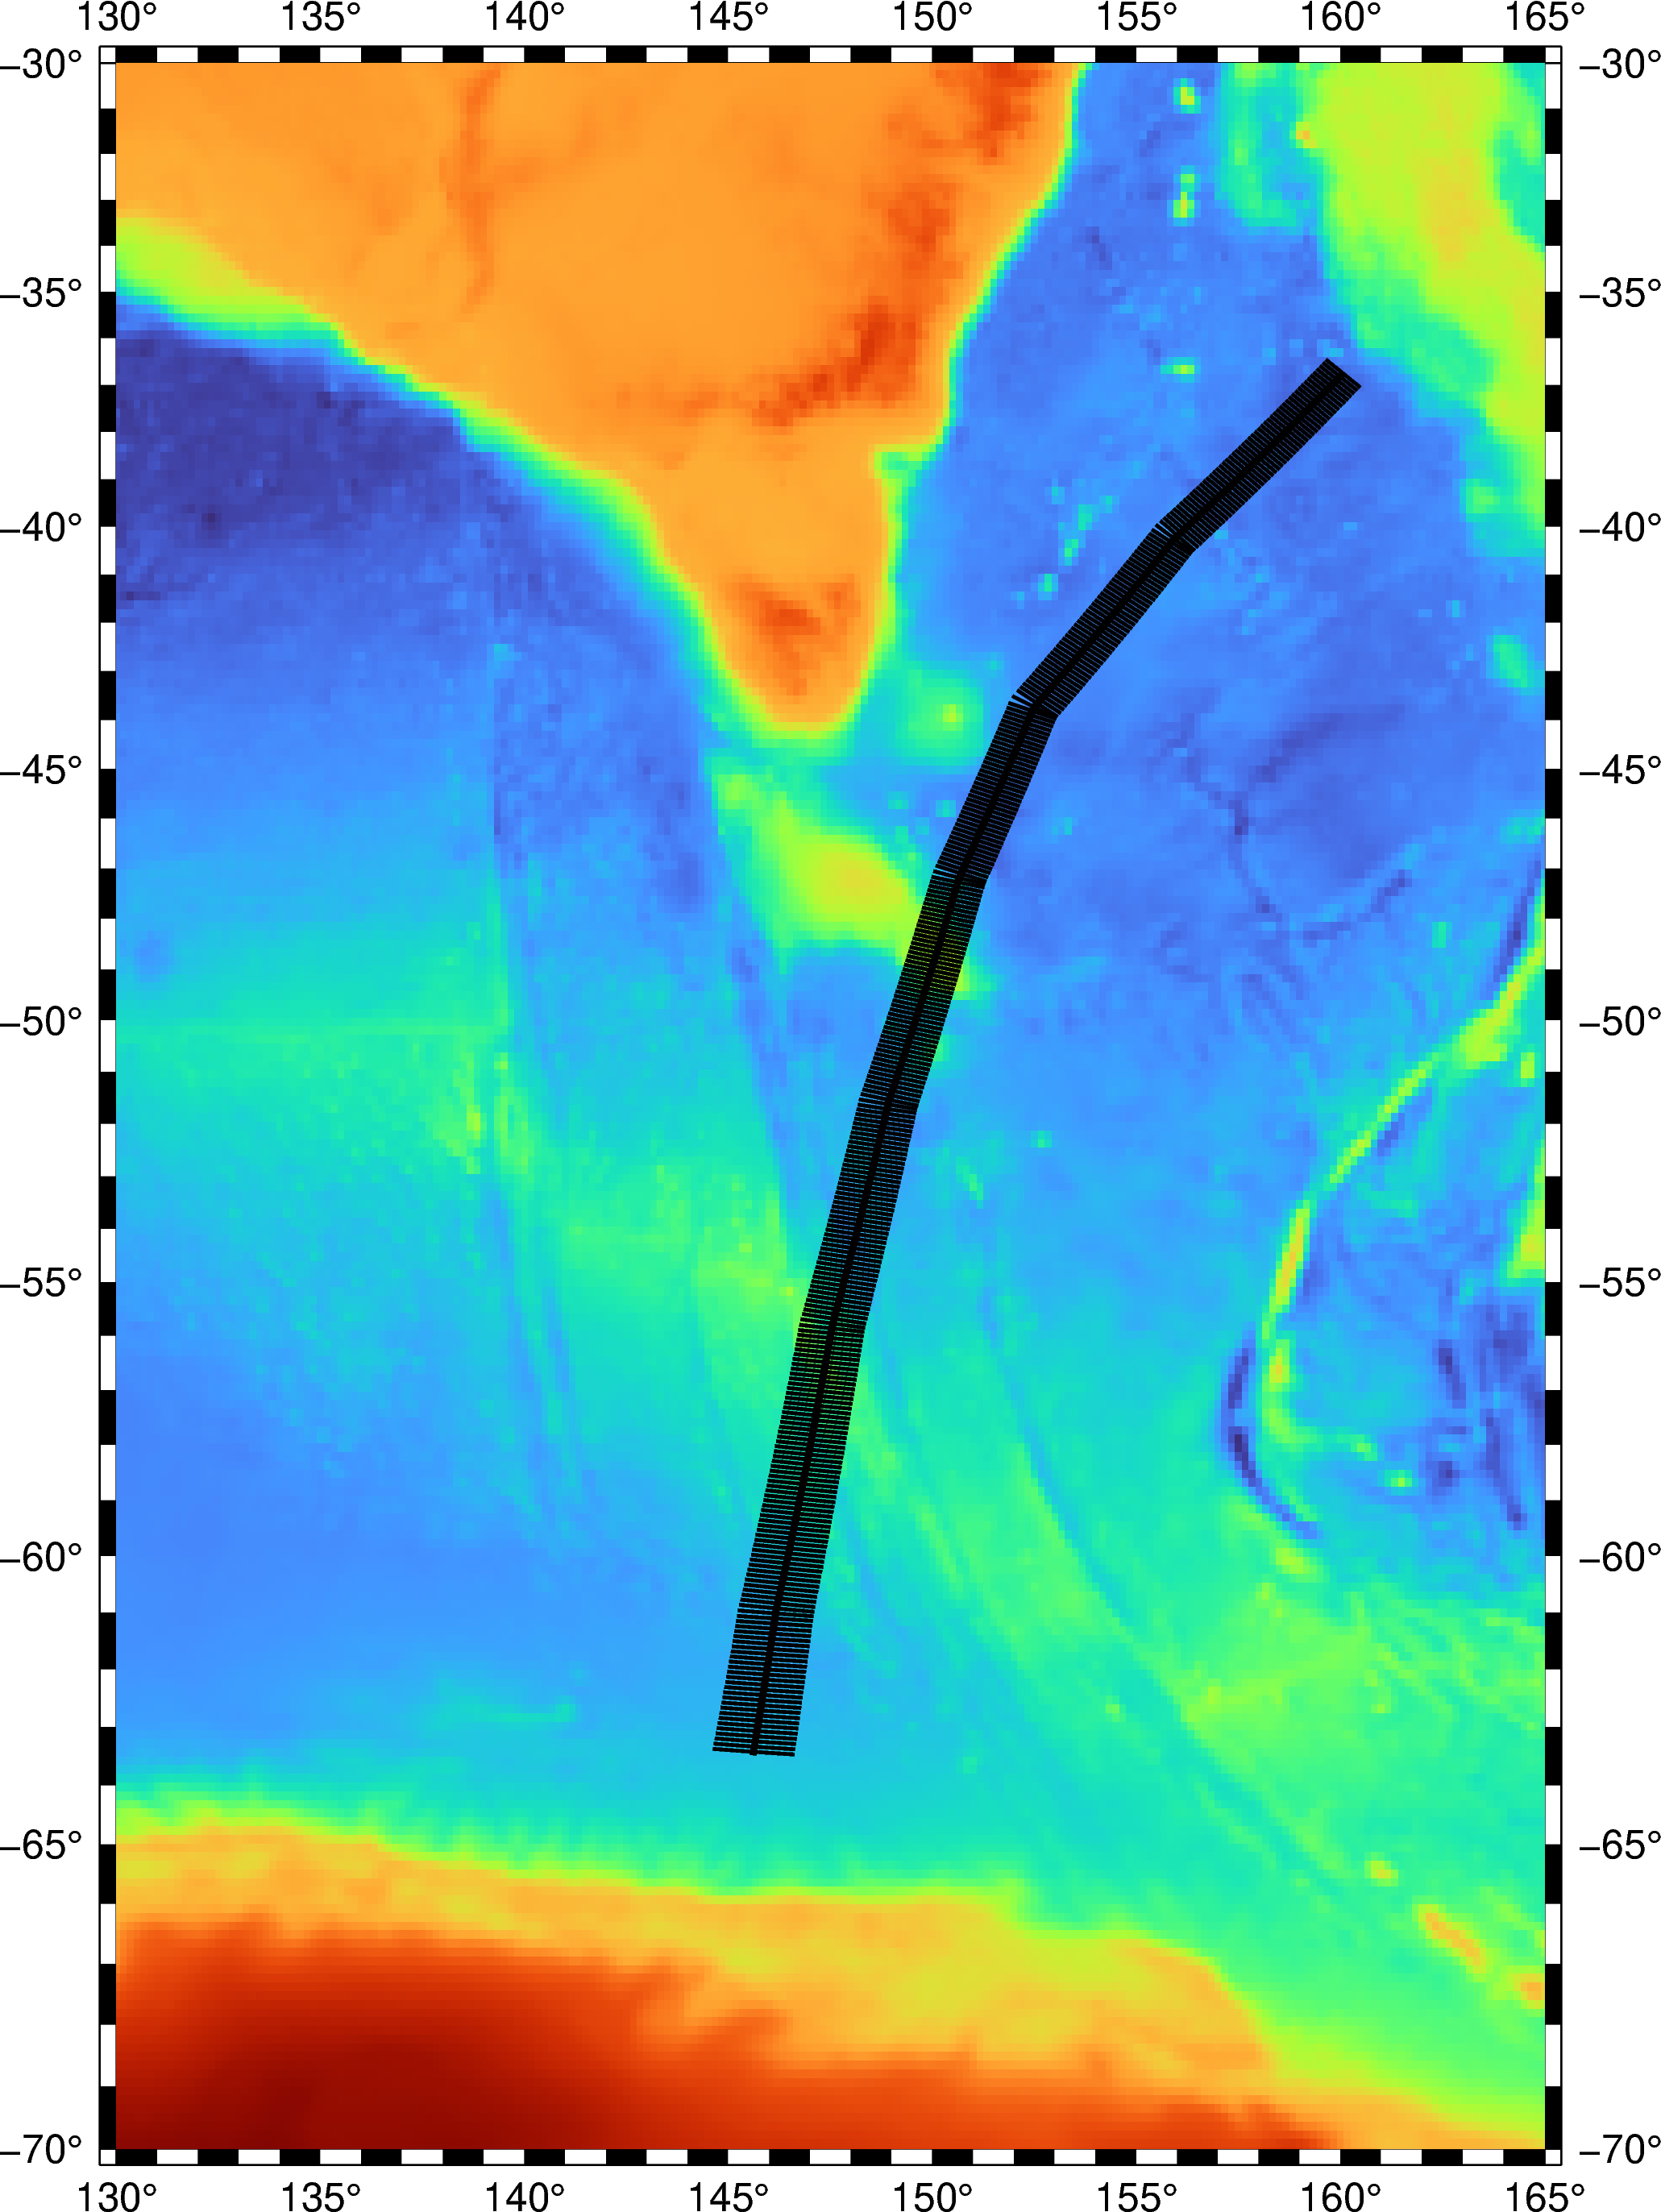

In [2]:
cross_track_width = 100.
along_track_spacing = 2.
cross_track_spacing = 10.

(along_track_distance, 
 swath_longitudes, 
 swath_latitudes, 
 swath_zvalues) = gmt_grdtrack(profile_line_file,
                               grdfile,
                               cross_track_width,
                               along_track_spacing,
                               cross_track_spacing)

fig = pygmt.Figure()
fig.basemap(frame='afg',
            region='130/165/-70/-30',
            projection='Cyl_stere/150/-20/15c',)
fig.grdimage(
    grid=grdfile)
fig.plot(
    data = profile_line_file,
    pen="2p,black",
)
fig.plot(
    data = 'table.txt',
    pen="1p,black",
)
fig.show()



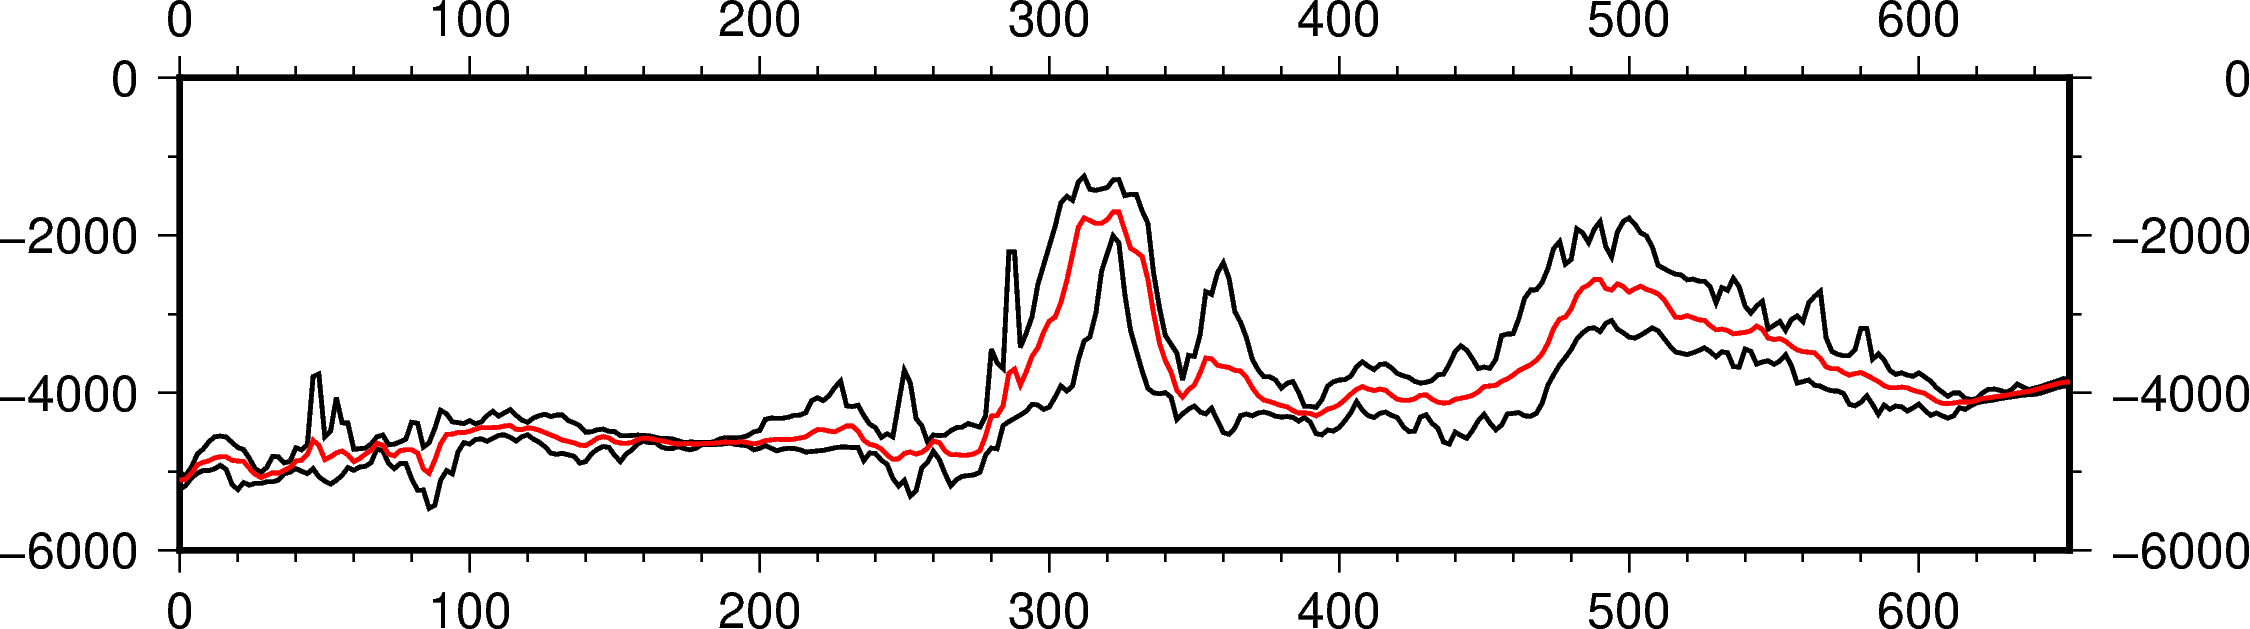

In [5]:
fig = pygmt.Figure()
fig.basemap(region = [0, along_track_distance.max(), -6000, 0], 
            projection='X16c/4c', frame=True)
fig.plot(x=along_track_distance, y=np.nanmin(swath_zvalues, axis=1), pen='1p,black')
fig.plot(x=along_track_distance, y=np.nanmax(swath_zvalues, axis=1), pen='1p,black')
fig.plot(x=along_track_distance, y=np.nanmean(swath_zvalues, axis=1), pen='1p,red')
fig.show(width=800)